In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fish_dataset/data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fish_dataset/data/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fish_dataset/data/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)


Found 5099 images belonging to 9 classes.
Found 895 images belonging to 9 classes.
Found 2654 images belonging to 9 classes.


In [ ]:
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def train_and_evaluate_model(model, name, epochs=10):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)

    # Save the model
    model.save(f"{name}_model.h5")

    # Classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    print(f"\n{name} Model Performance:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.legend()

    plt.show()

    return model, test_acc


In [ ]:
def create_pretrained_model(base_model, name, input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    base_model.trainable = False  # Freeze base layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


def create_custom_cnn(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        Input(shape=input_shape),  # Correct way to define input
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),  # Automatically flattens based on previous layer
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3526s 18s/step - accuracy: 0.2732 - loss: 2.1668 - val_accuracy: 0.6126 - val_loss: 1.2049
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 122s 626ms/step - accuracy: 0.5293 - loss: 1.3139 - val_accuracy: 0.7335 - val_loss: 0.7871
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.6133 - loss: 1.0445 - val_accuracy: 0.7628 - val_loss: 0.7436
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 122s 627ms/step - accuracy: 0.6834 - loss: 0.8711 - val_accuracy: 0.8819 - val_loss: 0.4396
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 122s 628ms/step - accuracy: 0.7521 - loss: 0.6978 - val_accuracy: 0.8965 - val_loss: 0.3743
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 620ms/step - accuracy: 0.7813 - loss: 0.6166 - val_accuracy: 0.9084 - val_loss: 0.3253
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 123s 632ms/step - accuracy: 0.7999 - loss: 0.5844 - val_accuracy: 0.8984 - val_loss: 0.3171
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.8172 - 

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step

CustomCNN Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.95      1.00      0.97       298
   fish sea_food gilt_head_bream       0.94      0.73      0.82       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       1.00      0.96      0.98       291
     fish sea_food red_sea_bream       0.77      0.96      0.85       273
          fish sea_food sea_bass       0.92      0.90      0.91       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.96      0.96      0.96       293
             fish sea_food trout       0.96      1.00      0.98       292

                        accuracy    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


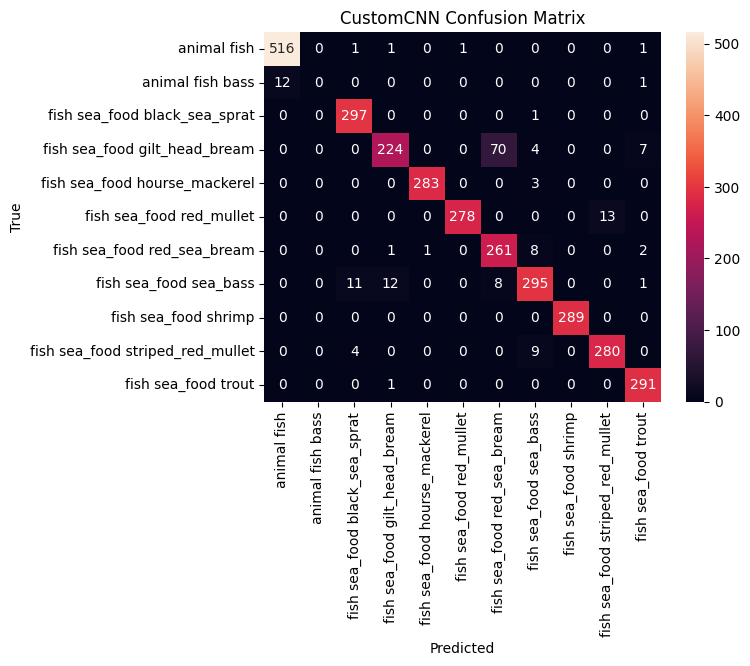

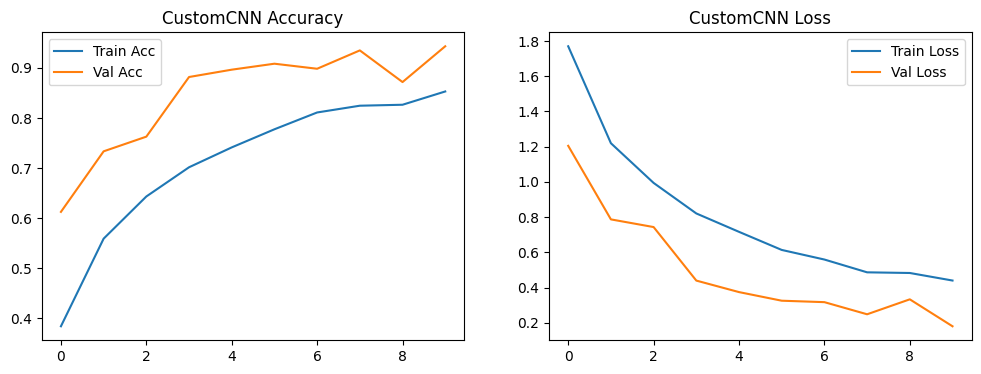

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


<ipython-input-15-d5c769783294>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'MobileNet': tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 168s 782ms/step - accuracy: 0.3690 - loss: 1.9217 - val_accuracy: 0.7051 - val_loss: 1.1302
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 136s 698ms/step - accuracy: 0.7553 - loss: 0.9935 - val_accuracy: 0.8571 - val_loss: 0.6412
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 138s 706ms/step - accuracy: 0.8486 - loss: 0.6218 - val_accuracy: 0.8965 - val_loss: 0.4541
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 702ms/step - accuracy: 0.8901 - loss: 0.4458 - val_accuracy: 0.9231 - val_loss: 0.3469
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 721ms/step - accuracy: 0.9128 - loss: 0.3438 - val_accuracy: 0.9103 - val_loss: 0.3224
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 139s 712ms/step - accuracy: 0.9298 - loss: 0.2915 - val_accuracy: 0.9405 - val_loss: 0.2528
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 136s 696ms/step

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step

VGG16 Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.99       520
                animal fish bass       0.83      0.38      0.53        13
   fish sea_food black_sea_sprat       0.98      0.99      0.98       298
   fish sea_food gilt_head_bream       0.97      0.96      0.97       305
   fish sea_food hourse_mackerel       0.96      0.99      0.98       286
        fish sea_food red_mullet       0.95      0.98      0.97       291
     fish sea_food red_sea_bream       0.95      1.00      0.98       273
          fish sea_food sea_bass       0.99      0.97      0.98       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.97      0.92      0.95       293
             fish sea_food trout       1.00      0.98      0.99       292

                        accuracy        

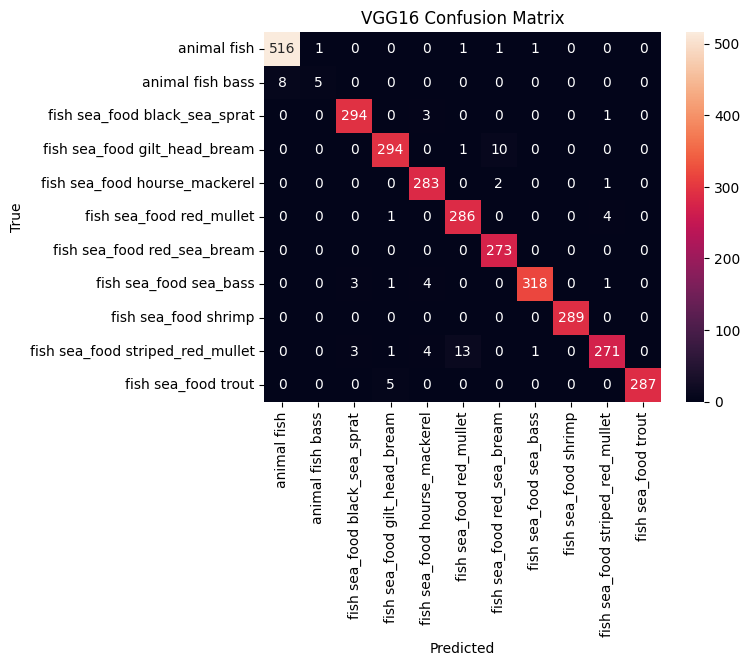

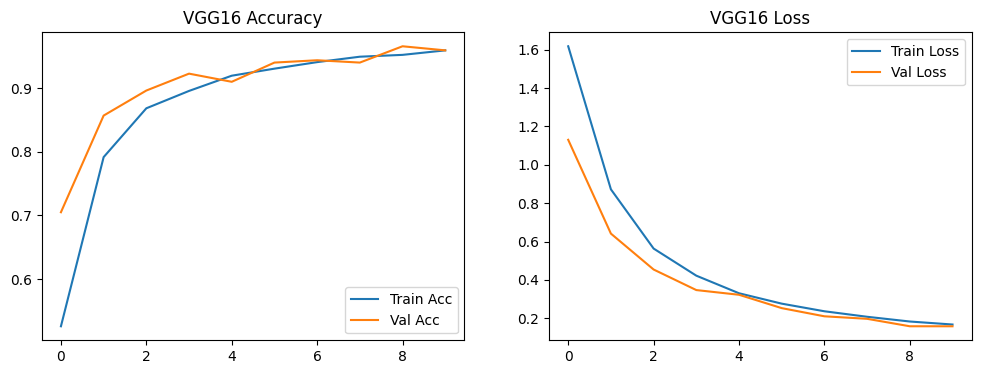

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 150s 696ms/step - accuracy: 0.1674 - loss: 2.3165 - val_accuracy: 0.2784 - val_loss: 2.1344
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 644ms/step - accuracy: 0.2376 - loss: 2.1242 - val_accuracy: 0.3013 - val_loss: 2.0183
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 635ms/step - accuracy: 0.2533 - loss: 2.0491 - val_accuracy: 0.2628 - val_loss: 2.0147
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 130s 669ms/step - accuracy: 0.2996 - loss: 1.9603 - val_accuracy: 0.2875 - val_loss: 1.9436
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 135s 635ms/step - accuracy: 0.3295 - loss: 1.9039 - val_accuracy: 0.2940 - val_loss: 1.9022
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 638ms/step - accuracy: 0.3342 - loss: 1.8668 - val_accuracy: 0.3617 - val_loss: 1.8311
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 649ms/step - accuracy: 0.3564 - loss: 1.8582 - val_accuracy: 0.3141 - val_loss: 1.9995
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 633ms/step - accuracy: 0.3559 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 211ms/step

ResNet50 Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       0.93      0.51      0.66       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.47      0.37      0.41       298
   fish sea_food gilt_head_bream       1.00      0.00      0.01       305
   fish sea_food hourse_mackerel       0.28      0.91      0.43       286
        fish sea_food red_mullet       0.61      0.30      0.40       291
     fish sea_food red_sea_bream       0.31      0.67      0.42       273
          fish sea_food sea_bass       0.48      0.26      0.34       327
            fish sea_food shrimp       0.43      0.75      0.55       289
fish sea_food striped_red_mullet       0.33      0.06      0.10       293
             fish sea_food trout       0.54      0.53      0.53       292

                        accuracy     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


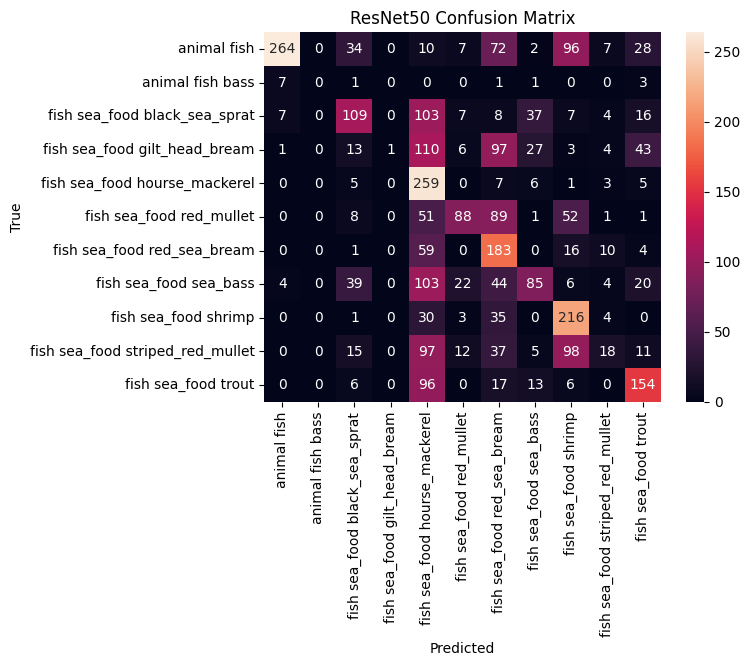

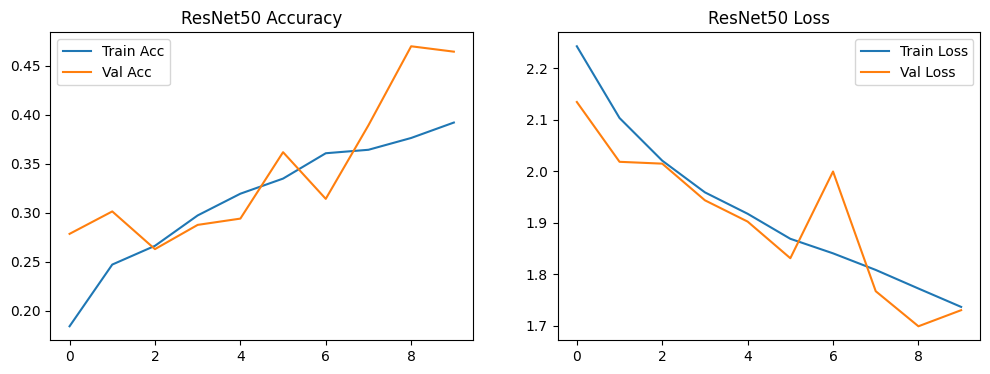

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 134s 647ms/step - accuracy: 0.7749 - loss: 0.7564 - val_accuracy: 0.9863 - val_loss: 0.0577
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 122s 623ms/step - accuracy: 0.9887 - loss: 0.0531 - val_accuracy: 0.9954 - val_loss: 0.0228
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 637ms/step - accuracy: 0.9917 - loss: 0.0329 - val_accuracy: 0.9918 - val_loss: 0.0307
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 136s 606ms/step - accuracy: 0.9941 - loss: 0.0242 - val_accuracy: 0.9973 - val_loss: 0.0123
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 145s 620ms/step - accuracy: 0.9922 - loss: 0.0251 - val_accuracy: 0.9954 - val_loss: 0.0215
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 614ms/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.9954 - val_loss: 0.0117
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 131s 675ms/step - accuracy: 0.9982 - loss: 0.0082 - val_accuracy: 0.9973 - val_loss: 0.0079
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 130s 668ms/step - accuracy: 0.9962 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step

MobileNet Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.62      0.76        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy    

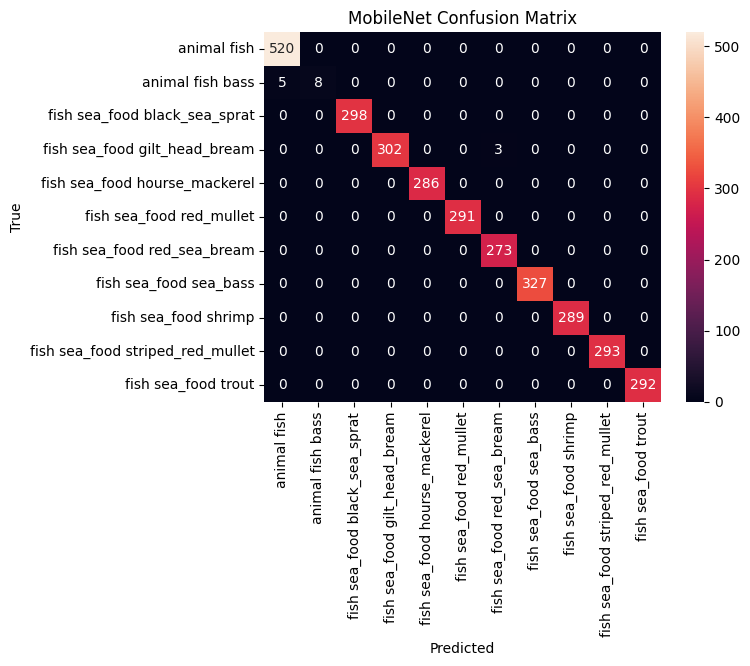

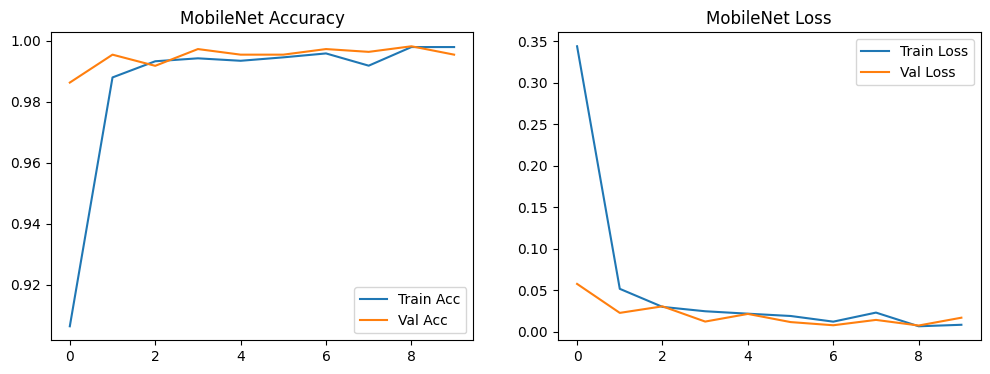

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 163s 747ms/step - accuracy: 0.7359 - loss: 0.8706 - val_accuracy: 0.9551 - val_loss: 0.1596
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 127s 651ms/step - accuracy: 0.9554 - loss: 0.1392 - val_accuracy: 0.9716 - val_loss: 0.1094
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 123s 631ms/step - accuracy: 0.9655 - loss: 0.1019 - val_accuracy: 0.9716 - val_loss: 0.0861
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 642ms/step - accuracy: 0.9774 - loss: 0.0722 - val_accuracy: 0.9762 - val_loss: 0.0685
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 643ms/step - accuracy: 0.9816 - loss: 0.0566 - val_accuracy: 0.9789 - val_loss: 0.0678
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 143s 647ms/step - accuracy: 0.9863 - loss: 0.0477 - val_accuracy: 0.9808 - val_loss: 0.0542
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 123s 631ms/step - accuracy: 0.9834 - loss: 0.0461 - val_accuracy: 0.9734 - val_loss: 0.0908
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.9823 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step

InceptionV3 Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       1.00      1.00      1.00       520
                animal fish bass       0.92      0.92      0.92        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       1.00      0.95      0.97       305
   fish sea_food hourse_mackerel       0.97      1.00      0.98       286
        fish sea_food red_mullet       1.00      0.99      0.99       291
     fish sea_food red_sea_bream       0.96      1.00      0.98       273
          fish sea_food sea_bass       1.00      0.97      0.98       327
            fish sea_food shrimp       0.99      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.97      0.98       293
             fish sea_food trout       0.97      1.00      0.98       292

                        accuracy  

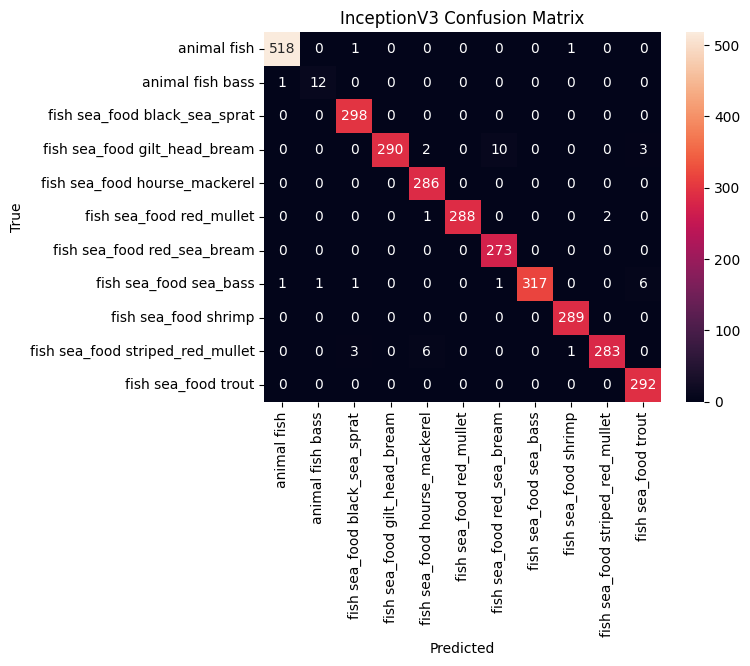

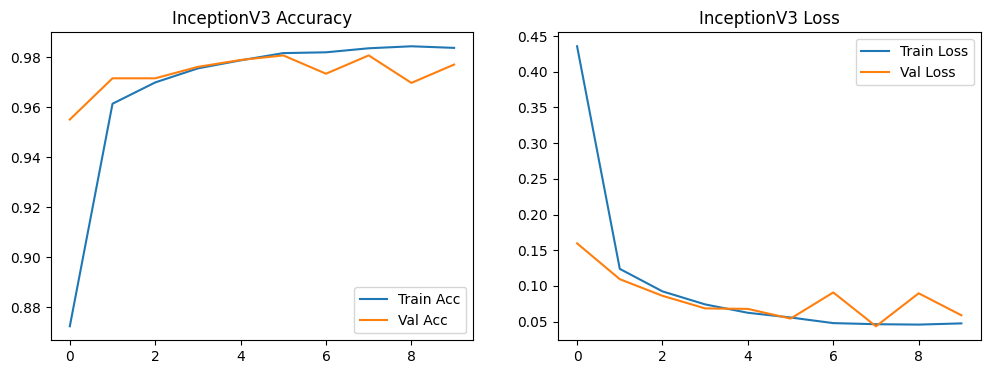

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 718ms/step - accuracy: 0.1643 - loss: 2.3305 - val_accuracy: 0.1712 - val_loss: 2.3141
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 618ms/step - accuracy: 0.1722 - loss: 2.3094 - val_accuracy: 0.1712 - val_loss: 2.3491
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 645ms/step - accuracy: 0.1776 - loss: 2.3086 - val_accuracy: 0.1712 - val_loss: 2.3315
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 137s 623ms/step - accuracy: 0.1731 - loss: 2.3065 - val_accuracy: 0.1712 - val_loss: 2.3250
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 613ms/step - accuracy: 0.1750 - loss: 2.3058 - val_accuracy: 0.1712 - val_loss: 2.3131
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 607ms/step - accuracy: 0.1822 - loss: 2.2991 - val_accuracy: 0.1712 - val_loss: 2.3111
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 121s 621ms/step - accuracy: 0.1834 - loss: 2.2952 - val_accuracy: 0.1712 - val_loss: 2.3199
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 613ms/step - accuracy: 0.1700 -

100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step

EfficientNetB0 Model Performance:
                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


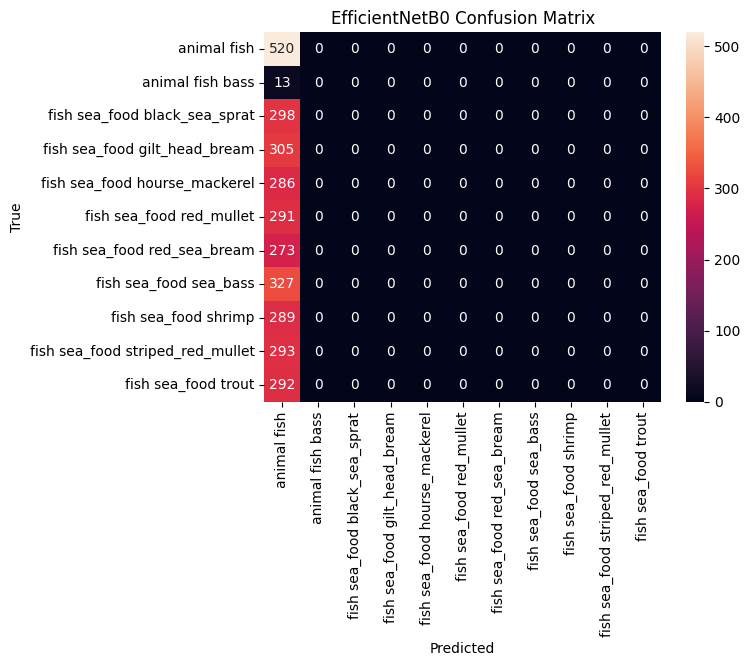

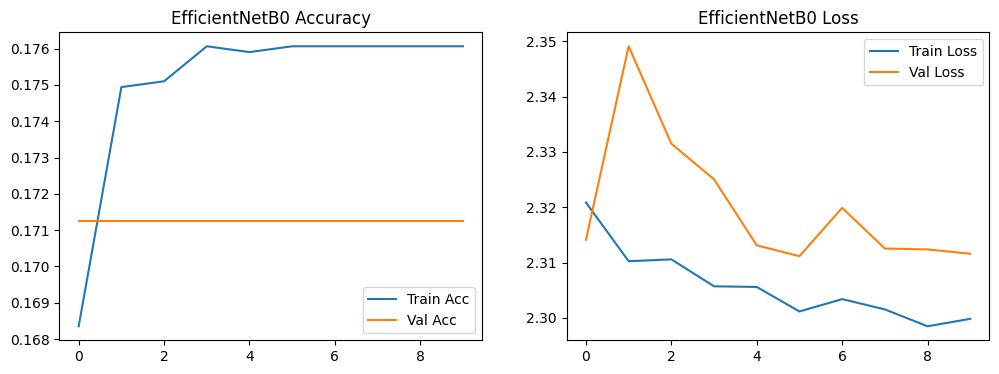

In [ ]:
results = {}

# Custom CNN
custom_model = create_custom_cnn()
model, acc = train_and_evaluate_model(custom_model, 'CustomCNN', epochs=10)
results['CustomCNN'] = acc

# Pre-trained models
pretrained_models = {
    'VGG16': tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'ResNet50': tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'MobileNet': tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'InceptionV3': tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'EfficientNetB0': tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
}

for name, base in pretrained_models.items():
    model = create_pretrained_model(base, name)
    model, acc = train_and_evaluate_model(model, name, epochs=10)
    results[name] = acc


In [ ]:
best_model_name = max(results, key=results.get)
print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]:.2f}")



Best Model: MobileNet with accuracy 1.00


<ipython-input-10-688f9d615164>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = tf.keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2642s 16s/step - accuracy: 0.7026 - loss: 0.9569 - val_accuracy: 0.9944 - val_loss: 0.0532
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 131s 822ms/step - accuracy: 0.9844 - loss: 0.0681 - val_accuracy: 0.9933 - val_loss: 0.0279
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 806ms/step - accuracy: 0.9905 - loss: 0.0393 - val_accuracy: 0.9978 - val_loss: 0.0135
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 810ms/step - accuracy: 0.9976 - loss: 0.0190 - val_accuracy: 0.9966 - val_loss: 0.0117
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 797ms/step - accuracy: 0.9961 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 804ms/step - accuracy: 0.9977 - loss: 0.0128 - val_accuracy: 0.9978 - val_loss: 0.0098
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 800ms/step - accuracy: 0.9983 - loss: 0.0091 - val_accuracy: 0.9989 - val_loss: 0.0056
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 790ms/step - accuracy: 0.9986 - 

83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step

MobileNet Model Performance:
                                  precision    recall  f1-score   support

   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      2654
                       macro avg       1.00      1.00      1.00      2654
                    weighted avg      

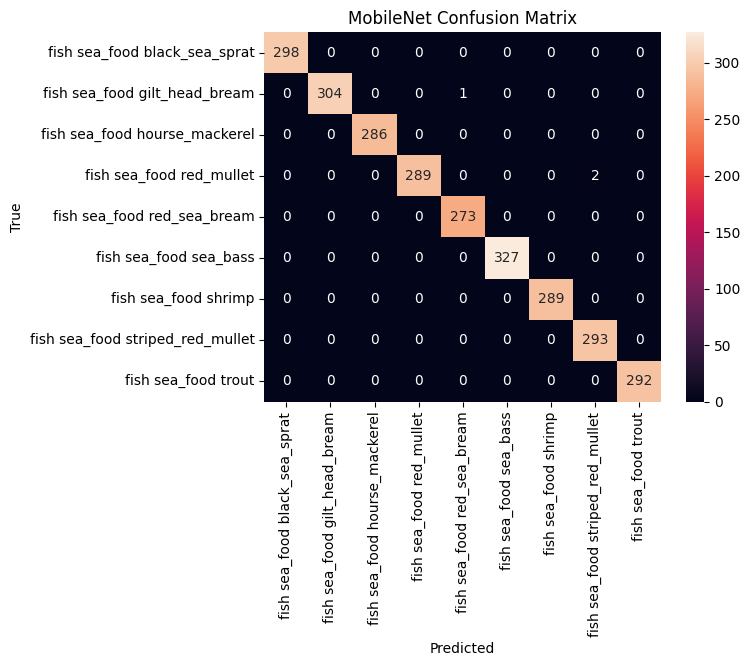

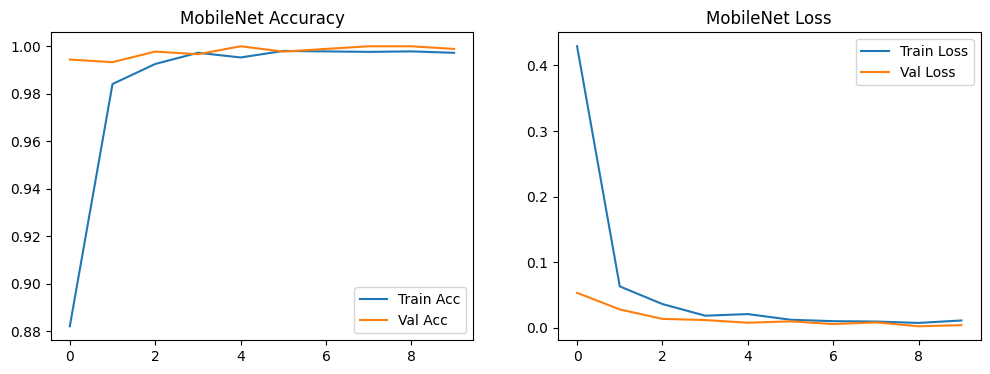

In [ ]:
# Set image size and import MobileNet base
IMG_SIZE = (256, 256)

mobilenet_base = tf.keras.applications.MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

# Create the MobileNet-based model
mobilenet_model = create_pretrained_model(mobilenet_base, 'MobileNet')

# Train and evaluate the model
mobilenet_model, mobilenet_history = train_and_evaluate_model(mobilenet_model, 'MobileNet', epochs=10)

# Save the model as .h5
mobilenet_model.save('/content/drive/MyDrive/Fish_models/MobileNet_best.h5')